In [6]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import keras.backend as K
from IPython.display import display, HTML
from keras.datasets import mnist
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

%matplotlib inline 

# Define Useful Fucntions

The following function creates one hot matrix as a matrix of binary values, with rows correspond to the class number and columns correspond to training examples.

In [7]:
"""
#labels: A vector containing the labels
#depth: number of classes
"""

def OneHot(labels, depth):

    depth = tf.constant(depth, name = "C")
    OneHotMatrix = tf.one_hot(labels,depth,axis=0)
    sess = tf.Session()
    OneHot = sess.run(OneHotMatrix)
    sess.close()
    
    return OneHot

The following function stops the training after reaching a pre-determined accuracy

In [11]:
'''
#epoch: index of epoch
#logs: results of calculated metrics from the training epoch
'''

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
    
        # Check accuracy
        if(logs.get('loss') < 0.01):

            # Stop the training if the given threshold is satisfied
            print("\nLoss is lower than 0.4 so cancelling training!")
            self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

# MNIST Data Preparation

In [9]:
(train_set, labels_orig), (test_set, labels_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Preparing the train, cross validation, and test sets.

We assign 20% of the training data samples to the cross validation set.

In [20]:
features_train = train_set[0:48000,:,:]
features_cross = train_set[48000:,:,:]
features_train = features_train.reshape(48000,28,28,1)
features_cross = features_cross.reshape(12000,28,28,1)
features_train = features_train/255.
features_cross = features_cross/255.

labels_train = labels_orig[0:48000,]
labels_cross = labels_orig[48000:,]
depth = 10
labels_train = OneHot(labels_train, depth).T
labels_cross = OneHot(labels_cross, depth).T

features_test = test_set.reshape(10000,28,28,1)
features_test = features_test/255.

print ("number of training examples = " + str(features_train.shape[0]))
print ("number of cross validation examples = " + str(features_cross.shape[0]))
print ("number of test examples = " + str(features_test.shape[0]))
print ("features_train shape: " + str(features_train.shape))
print ("features_cross shape: " + str(features_cross.shape))
print ("lables_train shape: " + str(labels_train.shape))
print ("lables_cross shape: " + str(labels_cross.shape))
print ("features_test shape: " + str(features_test.shape))

number of training examples = 48000
number of cross validation examples = 12000
number of test examples = 10000
features_train shape: (48000, 28, 28, 1)
features_cross shape: (12000, 28, 28, 1)
lables_train shape: (48000, 10)
lables_cross shape: (12000, 10)
features_test shape: (10000, 28, 28, 1)


# Creating the CNN with Residual blocks

The function below implements one residual block as the identity block.

In [21]:
"""
#X: activation of the previous layer
#f: (f,f) will be the shape of the filter for the middle layer, you can choose it while constructing model
#filters: A list of integers defining the number of filters in the main layer, you can choose it while constructing model
#identifier1 and identifier2: will be used to name the layers
#Returns X as output activation of the residual block
"""

def ResidualBlock_Identity(X, f, filters, identifier1, identifier2):

    ConvName = 'ResBlock' + str(identifier1) + identifier2 + '_level'
    BatchNormName = 'BatchNorm' + str(identifier1) + identifier2 + '_level'
    
    F1, F2, F3 = filters
     
    initial_X = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = ConvName + '2a', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = BatchNormName + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = ConvName + '2b', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = BatchNormName + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = ConvName + '2c', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = BatchNormName + '2c')(X)

    X = layers.Add()([X, initial_X])
    X = Activation('relu')(X)

    return X

The function below implements one residual block as the convolutional block.

In [22]:
"""
#X: activation of the previous layer
#f: (f,f) will be the shape of the filter for the middle layer, you can choose it while constructing model
#filters: A list of integers defining the number of filters in the main layer, you can choose it while constructing model
#identifier1 and identifier2: will be used to name the layers
#s: the number of strides used in the first layer
#Returns X as output activation of the residual block
"""

def ResidualBlock_Convolutional(X, f, filters, identifier1, identifier2, s = 2):
    
    ConvName = 'ResBlock' + str(identifier1) + identifier2 + '_level'
    BatchNormName = 'BatchNorm' + str(identifier1) + identifier2 + '_level'
    
    F1, F2, F3 = filters
    
    initial_X = X

    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = ConvName + '2a', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = BatchNormName + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = ConvName + '2b', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = BatchNormName + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = ConvName + '2c', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = BatchNormName + '2c')(X)

    initial_X = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = ConvName + '1', kernel_initializer = glorot_uniform(seed=None))(initial_X)
    initial_X = BatchNormalization(axis = 3, name = BatchNormName + '1')(initial_X)

    X = layers.Add()([X, initial_X])
    X = Activation('relu')(X)
    
    return X

The function below implements a CNN with residual blocks and uses a dropout regularizer.

It returns a Model() instance.

In [23]:
def CNNwithResidualBlocks(input_shape = (28, 28, 1), depth = 10):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (5, 5), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=None))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = ResidualBlock_Convolutional(X, f = 3, filters = [32, 32, 128], identifier1 = 2, identifier2='a', s = 1)
    X = ResidualBlock_Identity(X, 3, [32, 32, 128], identifier1=2, identifier2='b')
    
    X = ResidualBlock_Convolutional(X, f = 3, filters = [64,64,256], identifier1=3, identifier2='a', s = 2)
    X = ResidualBlock_Identity(X, 3, [64,64,256], identifier1=3, identifier2='b')

    X = ResidualBlock_Convolutional(X, f = 3, filters = [128, 128, 512], identifier1=4, identifier2='a', s = 1)
    X = ResidualBlock_Identity(X, 3, [128, 128, 512], identifier1=4, identifier2='b')
    
    X = ResidualBlock_Convolutional(X, f = 3, filters = [512, 512, 2048], identifier1=5, identifier2='a', s = 2)
    X = ResidualBlock_Identity(X, 3, [512, 512, 2048], identifier1=5, identifier2='b')

    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)
    
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(depth, activation='softmax', name='fullyconnected' + str(depth), kernel_initializer = glorot_uniform(seed=None))(X)
    
    model = Model(inputs = X_input, outputs = X, name='CNNwithResidualBlocks')

    return model

The following command creates the model w.r.t the shape of our training data points and class numbers.

In [24]:
model = CNNwithResidualBlocks(input_shape = (28, 28, 1), depth = 10)

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

# Training and Evaluation

Train the model on the training data set. 

You can choose the number of epochs or batch_size.

The callback is used during the training and stops the training procedure if the loss falls below a pre-determined value. You can remove it and let the training continues until the last epoch.

In [26]:
model.fit(features_train, labels_train, epochs = 15, batch_size = 256, callbacks=[callbacks], validation_data=(features_cross, labels_cross))

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 14s 299us/sample - loss: 0.3032 - acc: 0.9144 - val_loss: 6.9849 - val_acc: 0.1060
Epoch 2/15
48000/48000 [==============================] - 12s 260us/sample - loss: 0.0694 - acc: 0.9795 - val_loss: 6.4639 - val_acc: 0.1363
Epoch 3/15
48000/48000 [==============================] - 12s 259us/sample - loss: 0.0431 - acc: 0.9868 - val_loss: 0.4345 - val_acc: 0.8909
Epoch 4/15
48000/48000 [==============================] - 12s 257us/sample - loss: 0.0328 - acc: 0.9893 - val_loss: 0.0986 - val_acc: 0.9753
Epoch 5/15
48000/48000 [==============================] - 12s 256us/sample - loss: 0.0241 - acc: 0.9924 - val_loss: 0.0828 - val_acc: 0.9790
Epoch 6/15
48000/48000 [==============================] - 12s 257us/sample - loss: 0.0241 - acc: 0.9922 - val_loss: 0.0762 - val_acc: 0.9819
Epoch 7/15
48000/48000 [==============================] - 12s 257us/sample - loss: 0.0187 - acc: 0.9940 

Let's calculate the accuracy of the model on test data (previously unseen data).

In [27]:
predictions = model.evaluate(features_cross, labels_cross)
print ("Loss = " + str(predictions[0]))
print ("Test Accuracy = " + str(predictions[1]))

Loss = 0.07201894087206467
Test Accuracy = 0.98425


Do you think you can do better? Then, you can additioanlly tune the hyperparameters to improve the performance of the algorithm. Do it for yourself and let me know the results :)

Let's also obsevre the probability that each test image belongs to one of the 10 classes.

In [ ]:
Scores = model.predict(features_test)

If you are happy with the results, save the trained model, weights, etc. This can be used later for transfer learning, i.e., to use your already trained model to perform other different learning taks. How do you think it is possible?

You can load the saved model later.

In [ ]:
model.save('DigitRecognizer.h5')
#model = load_model('DigitRecognizer.h5')

The following command returns a summary of entire model with details about number of parameters in each layer, shape of activations in each layer, etc.


In [29]:
model.summary()

Model: "CNNwithResidualBlocks"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 34, 34, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 15, 15, 64)   1664        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 15, 15, 64)   256         ['conv1[0][0]

Let's compare the actual number with corresponding prediction. 

Choose an index for corresponding test image to compare the predicted digit with the actual hand-written digit in the corresponding image.


predicted_test_image = [4]
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[1.3463578e-07 1.1212269e-07 2.5250500e-07 3.1917562e-08 9.9805403e-01
  6.0506164e-07 5.6931913e-07 4.6782638e-06 1.0380440e-05 1.9292478e-03]]


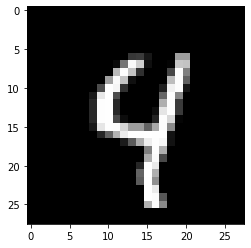

In [41]:
index = 1816
a = model.predict(features_test[index:(index + 1),:])
predicted = np.argmax(a, 1)
print("predicted_test_image = " + str(predicted)) 
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(a)
test_image = features_test[index,:]
test_image = test_image.reshape(28,28)
plt.imshow(test_image, cmap='gray')

The followig returns a data frame showing each ImageID in test data set and its corresponding predicted label.

In [42]:
PredictedLabels = np.argmax(Scores, 1)
PredictedLabels = pd.DataFrame(PredictedLabels, columns = ['Label'])
PredictedLabels.index += 1
PredictedLabels['ImageID'] = PredictedLabels.index
columnsTitles = ["ImageID","Label"]
Results = PredictedLabels.reindex(columns = columnsTitles)
print("Results :")
#Results.index.name="ImageID"
display(HTML(Results.to_html(index=False)))

Results :


ImageID,Label
1,7
2,2
3,1
4,0
5,4
6,1
7,4
8,9
9,5
10,9


Finally, let's convert the results to a csv file to showcase our results later if needed.

In [ ]:
Results.to_csv('Results.csv', index = False)